In [1]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_25.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_25.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_token.pth'


/home/guangwei/miniconda3/envs/zdh/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Extract hidden states/reference embeddings
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        
        # 访问最后一个隐藏层的最后一个token的隐藏状态
        # hidden_states[-1]表示最后一个隐藏层，mean(dim=1)表示取所有头的均值
        last_layer_hidden_states = outputs.hidden_states[-1]
        last_token_hidden_states = last_layer_hidden_states[:, -1, :]  # -1表示最后一个token
        hidden_states.append(last_token_hidden_states.cpu().numpy())
    return np.vstack(hidden_states)

def extract_reference_embeddings(references, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())
    return np.vstack(embeddings)

In [4]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [5]:
# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=500, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with accuracy {best_accuracy * 100:.2f}% at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    
    return custom_mlp, losses, best_accuracy

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 154/154 [00:38<00:00,  4.02it/s]


Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 154/154 [00:01<00:00, 100.48it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 200/200 [01:14<00:00,  2.69it/s]


Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 200/200 [00:02<00:00, 81.69it/s]


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=4864 and hidden_dim=256


Training Epochs:   3%|▎         | 14/500 [00:00<00:17, 27.18it/s]

Epoch 10/500, Loss: 1.6915
Test Accuracy at Epoch 10: 62.90%
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.62      0.89      0.73       160
non_infringement       0.67      0.28      0.40       123

        accuracy                           0.63       283
       macro avg       0.65      0.59      0.57       283
    weighted avg       0.64      0.63      0.59       283

New best model saved with accuracy 62.90% at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.62      0.89      0.73       160
non_infringement       0.67      0.28      0.40       123

        accuracy                           0.63       283
       macro avg       0.65      0.59      0.57       283
    weighted avg       0.64      0.63      0.59       283



Training Epochs:   5%|▍         | 23/500 [00:00<00:18, 25.45it/s]

Epoch 20/500, Loss: 0.4469
Test Accuracy at Epoch 20: 73.50%
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.78      0.74      0.76       160
non_infringement       0.68      0.73      0.71       123

        accuracy                           0.73       283
       macro avg       0.73      0.73      0.73       283
    weighted avg       0.74      0.73      0.74       283

New best model saved with accuracy 73.50% at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.78      0.74      0.76       160
non_infringement       0.68      0.73      0.71       123

        accuracy                           0.73       283
       macro avg       0.73      0.73      0.73       283
    weighted avg       0.74      0.73      0.74       283



Training Epochs:   7%|▋         | 34/500 [00:01<00:16, 27.45it/s]

Epoch 30/500, Loss: 0.4333
Test Accuracy at Epoch 30: 74.20%
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.79      0.74      0.77       160
non_infringement       0.69      0.74      0.71       123

        accuracy                           0.74       283
       macro avg       0.74      0.74      0.74       283
    weighted avg       0.75      0.74      0.74       283

New best model saved with accuracy 74.20% at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.79      0.74      0.77       160
non_infringement       0.69      0.74      0.71       123

        accuracy                           0.74       283
       macro avg       0.74      0.74      0.74       283
    weighted avg       0.75      0.74      0.74       283



Training Epochs:   9%|▉         | 44/500 [00:01<00:15, 28.58it/s]

Epoch 40/500, Loss: 0.3845
Test Accuracy at Epoch 40: 74.56%
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.89      0.62      0.74       160
non_infringement       0.65      0.90      0.76       123

        accuracy                           0.75       283
       macro avg       0.77      0.76      0.75       283
    weighted avg       0.79      0.75      0.74       283

New best model saved with accuracy 74.56% at epoch 40
Best Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.89      0.62      0.74       160
non_infringement       0.65      0.90      0.76       123

        accuracy                           0.75       283
       macro avg       0.77      0.76      0.75       283
    weighted avg       0.79      0.75      0.74       283



Training Epochs:  11%|█         | 56/500 [00:02<00:14, 30.04it/s]

Epoch 50/500, Loss: 0.3479
Test Accuracy at Epoch 50: 72.79%
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.82      0.66      0.73       160
non_infringement       0.65      0.81      0.72       123

        accuracy                           0.73       283
       macro avg       0.74      0.74      0.73       283
    weighted avg       0.75      0.73      0.73       283



Training Epochs:  13%|█▎        | 64/500 [00:02<00:16, 25.95it/s]

Epoch 60/500, Loss: 0.3080
Test Accuracy at Epoch 60: 73.14%
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.84      0.64      0.73       160
non_infringement       0.65      0.85      0.73       123

        accuracy                           0.73       283
       macro avg       0.75      0.74      0.73       283
    weighted avg       0.76      0.73      0.73       283



Training Epochs:  15%|█▍        | 73/500 [00:02<00:15, 28.42it/s]

Epoch 70/500, Loss: 0.2681
Test Accuracy at Epoch 70: 75.27%
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.83      0.71      0.77       160
non_infringement       0.68      0.80      0.74       123

        accuracy                           0.75       283
       macro avg       0.75      0.76      0.75       283
    weighted avg       0.76      0.75      0.75       283

New best model saved with accuracy 75.27% at epoch 70
Best Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.83      0.71      0.77       160
non_infringement       0.68      0.80      0.74       123

        accuracy                           0.75       283
       macro avg       0.75      0.76      0.75       283
    weighted avg       0.76      0.75      0.75       283



Training Epochs:  16%|█▋        | 82/500 [00:02<00:12, 34.12it/s]

Epoch 80/500, Loss: 0.2303
Test Accuracy at Epoch 80: 72.44%
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.76      0.75      0.75       160
non_infringement       0.68      0.69      0.69       123

        accuracy                           0.72       283
       macro avg       0.72      0.72      0.72       283
    weighted avg       0.72      0.72      0.72       283



Training Epochs:  19%|█▉        | 96/500 [00:03<00:11, 35.18it/s]

Epoch 90/500, Loss: 0.1973
Test Accuracy at Epoch 90: 68.90%
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.73      0.71      0.72       160
non_infringement       0.64      0.66      0.65       123

        accuracy                           0.69       283
       macro avg       0.68      0.69      0.68       283
    weighted avg       0.69      0.69      0.69       283



Training Epochs:  21%|██        | 105/500 [00:03<00:11, 35.22it/s]

Epoch 100/500, Loss: 0.1683
Test Accuracy at Epoch 100: 71.38%
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.74      0.77      0.75       160
non_infringement       0.68      0.64      0.66       123

        accuracy                           0.71       283
       macro avg       0.71      0.71      0.71       283
    weighted avg       0.71      0.71      0.71       283



Training Epochs:  23%|██▎       | 114/500 [00:03<00:11, 32.84it/s]

Epoch 110/500, Loss: 0.1436
Test Accuracy at Epoch 110: 67.84%
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.72      0.71      0.71       160
non_infringement       0.63      0.64      0.63       123

        accuracy                           0.68       283
       macro avg       0.67      0.67      0.67       283
    weighted avg       0.68      0.68      0.68       283



Training Epochs:  25%|██▍       | 124/500 [00:04<00:09, 37.87it/s]

Epoch 120/500, Loss: 0.2238
Test Accuracy at Epoch 120: 72.79%
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.72      0.85      0.78       160
non_infringement       0.74      0.57      0.65       123

        accuracy                           0.73       283
       macro avg       0.73      0.71      0.71       283
    weighted avg       0.73      0.73      0.72       283



Training Epochs:  27%|██▋       | 137/500 [00:04<00:09, 39.14it/s]

Epoch 130/500, Loss: 0.1442
Test Accuracy at Epoch 130: 68.20%
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.87      0.51      0.65       160
non_infringement       0.59      0.90      0.71       123

        accuracy                           0.68       283
       macro avg       0.73      0.71      0.68       283
    weighted avg       0.75      0.68      0.67       283



Training Epochs:  29%|██▉       | 145/500 [00:04<00:10, 35.34it/s]

Epoch 140/500, Loss: 0.1326
Test Accuracy at Epoch 140: 73.14%
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.83      0.66      0.74       160
non_infringement       0.65      0.82      0.73       123

        accuracy                           0.73       283
       macro avg       0.74      0.74      0.73       283
    weighted avg       0.75      0.73      0.73       283



Training Epochs:  31%|███       | 155/500 [00:04<00:08, 38.80it/s]

Epoch 150/500, Loss: 0.1436
Test Accuracy at Epoch 150: 68.90%
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.73      0.71      0.72       160
non_infringement       0.64      0.67      0.65       123

        accuracy                           0.69       283
       macro avg       0.68      0.69      0.69       283
    weighted avg       0.69      0.69      0.69       283



Training Epochs:  34%|███▎      | 168/500 [00:05<00:08, 39.46it/s]

Epoch 160/500, Loss: 0.1219
Test Accuracy at Epoch 160: 69.96%
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.74      0.73      0.73       160
non_infringement       0.65      0.66      0.66       123

        accuracy                           0.70       283
       macro avg       0.69      0.69      0.69       283
    weighted avg       0.70      0.70      0.70       283



Training Epochs:  34%|███▍      | 172/500 [00:05<00:09, 35.40it/s]

Epoch 170/500, Loss: 0.1049
Test Accuracy at Epoch 170: 69.26%
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.74      0.71      0.72       160
non_infringement       0.64      0.67      0.66       123

        accuracy                           0.69       283
       macro avg       0.69      0.69      0.69       283
    weighted avg       0.70      0.69      0.69       283



Training Epochs:  37%|███▋      | 187/500 [00:05<00:07, 41.72it/s]

Epoch 180/500, Loss: 0.0920
Test Accuracy at Epoch 180: 70.67%
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.75      0.71      0.73       160
non_infringement       0.65      0.70      0.67       123

        accuracy                           0.71       283
       macro avg       0.70      0.71      0.70       283
    weighted avg       0.71      0.71      0.71       283



Training Epochs:  39%|███▉      | 197/500 [00:06<00:08, 35.32it/s]

Epoch 190/500, Loss: 0.0829
Test Accuracy at Epoch 190: 70.32%
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.74      0.72      0.73       160
non_infringement       0.65      0.67      0.66       123

        accuracy                           0.70       283
       macro avg       0.70      0.70      0.70       283
    weighted avg       0.70      0.70      0.70       283



Training Epochs:  41%|████      | 206/500 [00:06<00:08, 35.00it/s]

Epoch 200/500, Loss: 0.0751
Test Accuracy at Epoch 200: 70.32%
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.74      0.72      0.73       160
non_infringement       0.65      0.67      0.66       123

        accuracy                           0.70       283
       macro avg       0.70      0.70      0.70       283
    weighted avg       0.70      0.70      0.70       283



Training Epochs:  43%|████▎     | 214/500 [00:06<00:08, 32.54it/s]

Epoch 210/500, Loss: 0.0690
Test Accuracy at Epoch 210: 69.61%
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.74      0.71      0.72       160
non_infringement       0.64      0.68      0.66       123

        accuracy                           0.70       283
       macro avg       0.69      0.69      0.69       283
    weighted avg       0.70      0.70      0.70       283



Training Epochs:  45%|████▍     | 223/500 [00:06<00:08, 34.49it/s]

Epoch 220/500, Loss: 0.0642
Test Accuracy at Epoch 220: 69.96%
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.75      0.71      0.73       160
non_infringement       0.65      0.68      0.66       123

        accuracy                           0.70       283
       macro avg       0.70      0.70      0.70       283
    weighted avg       0.70      0.70      0.70       283



Training Epochs:  47%|████▋     | 236/500 [00:07<00:07, 33.86it/s]

Epoch 230/500, Loss: 0.0604
Test Accuracy at Epoch 230: 69.96%
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.75      0.71      0.73       160
non_infringement       0.65      0.68      0.66       123

        accuracy                           0.70       283
       macro avg       0.70      0.70      0.70       283
    weighted avg       0.70      0.70      0.70       283



Training Epochs:  49%|████▉     | 246/500 [00:07<00:06, 37.11it/s]

Epoch 240/500, Loss: 0.0575
Test Accuracy at Epoch 240: 70.67%
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.75      0.72      0.74       160
non_infringement       0.66      0.68      0.67       123

        accuracy                           0.71       283
       macro avg       0.70      0.70      0.70       283
    weighted avg       0.71      0.71      0.71       283



Training Epochs:  50%|█████     | 250/500 [00:07<00:06, 36.52it/s]

Epoch 250/500, Loss: 0.0551
Test Accuracy at Epoch 250: 70.67%
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.75      0.72      0.74       160
non_infringement       0.66      0.68      0.67       123

        accuracy                           0.71       283
       macro avg       0.70      0.70      0.70       283
    weighted avg       0.71      0.71      0.71       283



Training Epochs:  52%|█████▏    | 262/500 [00:08<00:07, 31.97it/s]

Epoch 260/500, Loss: 0.0532
Test Accuracy at Epoch 260: 70.32%
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.75      0.72      0.73       160
non_infringement       0.65      0.68      0.67       123

        accuracy                           0.70       283
       macro avg       0.70      0.70      0.70       283
    weighted avg       0.71      0.70      0.70       283



Training Epochs:  55%|█████▍    | 274/500 [00:08<00:06, 32.80it/s]

Epoch 270/500, Loss: 0.0518
Test Accuracy at Epoch 270: 70.32%
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.75      0.72      0.73       160
non_infringement       0.65      0.68      0.67       123

        accuracy                           0.70       283
       macro avg       0.70      0.70      0.70       283
    weighted avg       0.71      0.70      0.70       283



Training Epochs:  57%|█████▋    | 286/500 [00:08<00:06, 31.38it/s]

Epoch 280/500, Loss: 0.0504
Test Accuracy at Epoch 280: 71.38%
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       160
non_infringement       0.66      0.70      0.68       123

        accuracy                           0.71       283
       macro avg       0.71      0.71      0.71       283
    weighted avg       0.72      0.71      0.71       283



Training Epochs:  59%|█████▉    | 294/500 [00:09<00:07, 29.16it/s]

Epoch 290/500, Loss: 0.0493
Test Accuracy at Epoch 290: 71.38%
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       160
non_infringement       0.66      0.70      0.68       123

        accuracy                           0.71       283
       macro avg       0.71      0.71      0.71       283
    weighted avg       0.72      0.71      0.71       283



Training Epochs:  60%|██████    | 302/500 [00:09<00:06, 32.04it/s]

Epoch 300/500, Loss: 0.0485
Test Accuracy at Epoch 300: 71.02%
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       160
non_infringement       0.66      0.70      0.68       123

        accuracy                           0.71       283
       macro avg       0.71      0.71      0.71       283
    weighted avg       0.71      0.71      0.71       283



Training Epochs:  63%|██████▎   | 314/500 [00:09<00:05, 32.00it/s]

Epoch 310/500, Loss: 0.0477
Test Accuracy at Epoch 310: 71.73%
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       160
non_infringement       0.66      0.71      0.69       123

        accuracy                           0.72       283
       macro avg       0.71      0.72      0.71       283
    weighted avg       0.72      0.72      0.72       283



Training Epochs:  65%|██████▌   | 326/500 [00:10<00:05, 32.83it/s]

Epoch 320/500, Loss: 0.0472
Test Accuracy at Epoch 320: 71.73%
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       160
non_infringement       0.66      0.71      0.69       123

        accuracy                           0.72       283
       macro avg       0.71      0.72      0.71       283
    weighted avg       0.72      0.72      0.72       283



Training Epochs:  67%|██████▋   | 334/500 [00:10<00:05, 31.44it/s]

Epoch 330/500, Loss: 0.0466
Test Accuracy at Epoch 330: 71.38%
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       160
non_infringement       0.66      0.71      0.68       123

        accuracy                           0.71       283
       macro avg       0.71      0.71      0.71       283
    weighted avg       0.72      0.71      0.71       283



Training Epochs:  68%|██████▊   | 342/500 [00:10<00:05, 29.63it/s]

Epoch 340/500, Loss: 0.0462
Test Accuracy at Epoch 340: 71.73%
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.77      0.72      0.74       160
non_infringement       0.66      0.72      0.69       123

        accuracy                           0.72       283
       macro avg       0.71      0.72      0.71       283
    weighted avg       0.72      0.72      0.72       283



Training Epochs:  71%|███████   | 354/500 [00:11<00:04, 29.71it/s]

Epoch 350/500, Loss: 0.0458
Test Accuracy at Epoch 350: 72.08%
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.77      0.72      0.75       160
non_infringement       0.67      0.72      0.69       123

        accuracy                           0.72       283
       macro avg       0.72      0.72      0.72       283
    weighted avg       0.72      0.72      0.72       283



Training Epochs:  72%|███████▏  | 362/500 [00:11<00:04, 32.14it/s]

Epoch 360/500, Loss: 0.0455
Test Accuracy at Epoch 360: 72.08%
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.77      0.72      0.75       160
non_infringement       0.67      0.72      0.69       123

        accuracy                           0.72       283
       macro avg       0.72      0.72      0.72       283
    weighted avg       0.72      0.72      0.72       283



Training Epochs:  75%|███████▍  | 374/500 [00:11<00:03, 32.23it/s]

Epoch 370/500, Loss: 0.0452
Test Accuracy at Epoch 370: 72.08%
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.77      0.72      0.75       160
non_infringement       0.67      0.72      0.69       123

        accuracy                           0.72       283
       macro avg       0.72      0.72      0.72       283
    weighted avg       0.72      0.72      0.72       283



Training Epochs:  77%|███████▋  | 386/500 [00:12<00:03, 31.95it/s]

Epoch 380/500, Loss: 0.0450
Test Accuracy at Epoch 380: 71.38%
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       160
non_infringement       0.66      0.71      0.68       123

        accuracy                           0.71       283
       macro avg       0.71      0.71      0.71       283
    weighted avg       0.72      0.71      0.71       283



Training Epochs:  79%|███████▉  | 394/500 [00:12<00:03, 30.72it/s]

Epoch 390/500, Loss: 0.0447
Test Accuracy at Epoch 390: 71.73%
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       160
non_infringement       0.66      0.71      0.69       123

        accuracy                           0.72       283
       macro avg       0.71      0.72      0.71       283
    weighted avg       0.72      0.72      0.72       283



Training Epochs:  81%|████████  | 403/500 [00:12<00:03, 29.28it/s]

Epoch 400/500, Loss: 0.0445
Test Accuracy at Epoch 400: 71.73%
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       160
non_infringement       0.66      0.71      0.69       123

        accuracy                           0.72       283
       macro avg       0.71      0.72      0.71       283
    weighted avg       0.72      0.72      0.72       283



Training Epochs:  82%|████████▏ | 412/500 [00:12<00:02, 34.30it/s]

Epoch 410/500, Loss: 0.0444
Test Accuracy at Epoch 410: 71.38%
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       160
non_infringement       0.66      0.71      0.68       123

        accuracy                           0.71       283
       macro avg       0.71      0.71      0.71       283
    weighted avg       0.72      0.71      0.71       283



Training Epochs:  85%|████████▌ | 426/500 [00:13<00:01, 37.00it/s]

Epoch 420/500, Loss: 0.0444
Test Accuracy at Epoch 420: 71.38%
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       160
non_infringement       0.66      0.71      0.68       123

        accuracy                           0.71       283
       macro avg       0.71      0.71      0.71       283
    weighted avg       0.72      0.71      0.71       283



Training Epochs:  87%|████████▋ | 436/500 [00:13<00:01, 38.59it/s]

Epoch 430/500, Loss: 0.0441
Test Accuracy at Epoch 430: 71.38%
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       160
non_infringement       0.66      0.71      0.68       123

        accuracy                           0.71       283
       macro avg       0.71      0.71      0.71       283
    weighted avg       0.72      0.71      0.71       283



Training Epochs:  89%|████████▉ | 447/500 [00:13<00:01, 44.22it/s]

Epoch 440/500, Loss: 0.0440
Test Accuracy at Epoch 440: 71.38%
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       160
non_infringement       0.66      0.71      0.68       123

        accuracy                           0.71       283
       macro avg       0.71      0.71      0.71       283
    weighted avg       0.72      0.71      0.71       283



Training Epochs:  91%|█████████▏| 457/500 [00:14<00:01, 37.56it/s]

Epoch 450/500, Loss: 0.0438
Test Accuracy at Epoch 450: 71.38%
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       160
non_infringement       0.66      0.71      0.68       123

        accuracy                           0.71       283
       macro avg       0.71      0.71      0.71       283
    weighted avg       0.72      0.71      0.71       283



Training Epochs:  92%|█████████▏| 462/500 [00:14<00:01, 34.22it/s]

Epoch 460/500, Loss: 0.0437
Test Accuracy at Epoch 460: 71.38%
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       160
non_infringement       0.66      0.71      0.68       123

        accuracy                           0.71       283
       macro avg       0.71      0.71      0.71       283
    weighted avg       0.72      0.71      0.71       283



Training Epochs:  96%|█████████▌| 479/500 [00:14<00:00, 44.41it/s]

Epoch 470/500, Loss: 0.0437
Test Accuracy at Epoch 470: 71.73%
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       160
non_infringement       0.66      0.71      0.69       123

        accuracy                           0.72       283
       macro avg       0.71      0.72      0.71       283
    weighted avg       0.72      0.72      0.72       283



Training Epochs:  97%|█████████▋| 484/500 [00:14<00:00, 41.82it/s]

Epoch 480/500, Loss: 0.0438
Test Accuracy at Epoch 480: 71.73%
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       160
non_infringement       0.66      0.71      0.69       123

        accuracy                           0.72       283
       macro avg       0.71      0.72      0.71       283
    weighted avg       0.72      0.72      0.72       283

Epoch 490/500, Loss: 0.0435


Training Epochs:  98%|█████████▊| 490/500 [00:14<00:00, 43.52it/s]

Test Accuracy at Epoch 490: 71.38%
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       160
non_infringement       0.66      0.70      0.68       123

        accuracy                           0.71       283
       macro avg       0.71      0.71      0.71       283
    weighted avg       0.72      0.71      0.71       283



Training Epochs: 100%|██████████| 500/500 [00:15<00:00, 32.78it/s]
/tmp/ipykernel_2528362/1033092828.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_sta

Epoch 500/500, Loss: 0.0434
Test Accuracy at Epoch 500: 71.38%
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       160
non_infringement       0.66      0.70      0.68       123

        accuracy                           0.71       283
       macro avg       0.71      0.71      0.71       283
    weighted avg       0.72      0.71      0.71       283



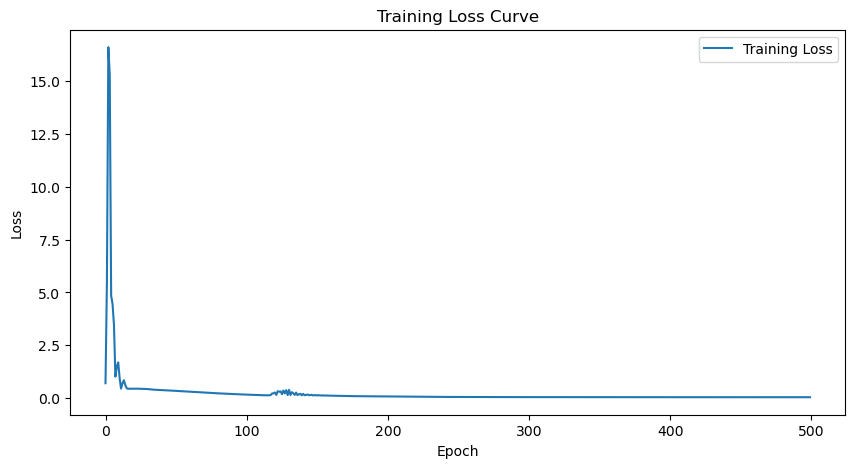

Final Model Accuracy: 75.27%


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_token.pth'.


In [11]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

/tmp/ipykernel_2528362/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()


                  precision    recall  f1-score   support

    infringement       0.83      0.71      0.77       160
non_infringement       0.68      0.80      0.74       123

        accuracy                           0.75       283
       macro avg       0.75      0.76      0.75       283
    weighted avg       0.76      0.75      0.75       283

